In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
import math
import time
import logging
import matplotlib.pyplot as plt
import itertools
import numpy as np
from tqdm import tqdm
import torchvision.utils as vutils
import os
import textwrap
import torch.optim as optim

#optuna
import optuna
from optuna.trial import TrialState
from optuna.artifacts import FileSystemArtifactStore
from optuna.artifacts import upload_artifact

#optuna dashboard packages
from optuna_dashboard import save_note, register_objective_form_widgets, ChoiceWidget
from optuna_dashboard.artifact import get_artifact_path

torch.manual_seed(111)

device = "cuda" if torch.cuda.is_available() else "cpu"

/home/mayank_khulbe_farmart_co/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_mnist_loaders(train_batch_size, test_batch_size):
    """Get MNIST data loaders"""
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,))
                       ])),
        batch_size=train_batch_size, shuffle=True)

    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,))
                       ])),
        batch_size=test_batch_size, shuffle=True)

    return train_loader, test_loader

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(128, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

In [5]:
def train_discriminator(discriminator, images, real_labels, fake_images, fake_labels, criterion, d_optimizer):
    discriminator.zero_grad()
    outputs = discriminator(images)
    real_loss = criterion(outputs, real_labels.unsqueeze(1))
    real_score = outputs

    outputs = discriminator(fake_images)
    fake_loss = criterion(outputs, fake_labels.unsqueeze(1))
    fake_score = outputs

    d_loss = real_loss + fake_loss
    d_loss.backward()

    d_optimizer.step()
    return d_loss, real_score, fake_score

In [6]:
def train_generator(generator, discriminator_outputs, real_labels, criterion, g_optimizer):
    generator.zero_grad()
    g_loss = criterion(discriminator_outputs, real_labels.unsqueeze(1))
    g_loss.backward()

    g_optimizer.step()
    return g_loss

In [7]:
# Plot grid of 9 images from generator after each epoch
def generate_new_images(generator, sample_images, latent_dim, img_dir):
    fixed_noise = torch.randn(sample_images, latent_dim).to(device)  # Sample 15 images
    fake_images = generator(fixed_noise).to(device)

    plt.figure(figsize=(5, 5))
    plt.axis("off")
    plt.title("Generated Images")
    plt.imshow(
        np.transpose(
            vutils.make_grid(fake_images, nrow=5, padding=1, normalize=True).cpu().numpy(),
            (1, 2, 0)
        )
    )
    plt.savefig(img_dir)
    plt.show()
    plt.close()

In [8]:
def train_GANs(study: optuna.Study,
               artifact_store: FileSystemArtifactStore):

    trial = study.ask() #start a trial

    print(f"running trial number: {trial.number}")

    latent_dim = 128

    #define the generator and the discriminator
    discriminator = Discriminator().to(device=device)
    generator = Generator().to(device=device)

    cfg = {
        "train_batch_size": trial.suggest_categorical("train_batch_size", [64, 128]),
        "device": "cuda" if torch.cuda.is_available() else "cpu",
        "num_epochs": 100,
        "lr": trial.suggest_float("lr", 1e-5, 1e-3, log=True),
        "optimizer": trial.suggest_categorical("optimizer", ["Adam", "AdamW"])
    }

    #define the loader
    batch_size = cfg["train_batch_size"]
    train_loader, _ = get_mnist_loaders(batch_size, batch_size)


    #define the optimizers
    lr = cfg['lr']
    optimizer_name = cfg['optimizer']
    d_optimizer = getattr(optim, optimizer_name)(discriminator.parameters(), lr=lr)  # Instantiate optimizer from name
    g_optimizer = getattr(optim, optimizer_name)(generator.parameters(), lr=lr)  # Instantiate optimizer from name

    #define the criterion
    criterion = nn.BCELoss()

    print(f"Batch Size: {batch_size}\nLearning Rate: {lr}\nOptimizer: {optimizer_name}")

    for epoch in range(cfg['num_epochs']):

        print(f"running epoch number: {epoch}")

        for n, (images, _) in tqdm(enumerate(train_loader)):
            images = images.to(device)
            real_labels = torch.ones(images.size(0)).to(device)

            noise = torch.randn(images.size(0), latent_dim).to(device)
            fake_images = generator(noise)
            fake_labels = torch.zeros(images.size(0)).to(device)

            # Train the discriminator
            d_loss, real_score, fake_score = train_discriminator(discriminator, images,
                                                                 real_labels, fake_images, fake_labels,
                                                                  criterion, d_optimizer)

            noise = torch.randn(images.size(0), latent_dim).to(device)
            fake_images = generator(noise)
            outputs = discriminator(fake_images)

            # Train the generator
            g_loss = train_generator(generator, outputs, real_labels, criterion, g_optimizer)

            if (n+1) % len(train_loader) == 0:

                print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, g_loss: %.4f, '
                    'D(x): %.2f, D(G(z)): %.2f'
                    % (epoch + 1, cfg['num_epochs'], n + 1, len(train_loader), d_loss.item(), g_loss.item(),
                        real_score.mean().item(), fake_score.mean().item()))

    img_path = f"tmp/generated_image-{trial.number}.png"
    generate_new_images(generator, 30, latent_dim, img_path)

    artifacts_id = upload_artifact(trial, img_path, artifact_store)
    artifact_path = get_artifact_path(trial, artifacts_id)

    # 4. Save Note
    note = textwrap.dedent(
        f"""\
    ## Trial {trial.number}

    Grid of GAN generated images!!
    ![generated-images]({artifact_path})

    d_loss: {d_loss.item():.2f}\n g_loss: {g_loss.item():.2f}
    """
    )
    save_note(trial, note)

    return g_loss.item(), d_loss.item()

In [9]:
def start_optimization(artifact_store: FileSystemArtifactStore):
    # 1. Create Study
    storage = "sqlite:///db.sqlite3"
    study = optuna.create_study(study_name="HITL_with_optuna_for_digit_generation",
                                directions=['minimize', 'maximize'],
                                storage=storage,
                                load_if_exists=True)

    # 2. Set an objective name
    study.set_metric_names(["Are you satisfied with the model's generated images?", "Are you satisfied with the discriminator's performance?"])

    # 3. Register ChoiceWidget
    register_objective_form_widgets(
    study,
    widgets=[
        ChoiceWidget(
            choices=["Yes 👍", "Somewhat 👌", "No 👎"],
            values=[-1, 0, 1],
            description="Please input your score for generated images!",
        ),
        ChoiceWidget(
            choices=["Yes 👍", "Somewhat 👌", "No 👎"],
            values=[1, 0, -1],
            description="Please input your score for model performance!",
        ),
    ],
)

    # 4. Start Human-in-the-loop Optimization
    n_batch = 4
    while True:
        running_trials = study.get_trials(deepcopy=False, states=(TrialState.RUNNING,))
        if len(running_trials) >= n_batch:
            time.sleep(1)  # Avoid busy-loop
            continue
        train_GANs(study, artifact_store)

In [10]:
def main():
    # tmp_path = os.path.join(os.path.dirname(__file__), "tmp")
    # Get the absolute path to the current notebook file
    notebook_dir = os.getcwd()

    # Create the absolute path to the "tmp" folder
    tmp_path = os.path.join(notebook_dir, "tmp")

    # 1. Create Artifact Store
    # artifact_path = os.path.join(os.path.dirname(__file__), "artifact")
    artifact_path = os.path.join(notebook_dir, "artifact")
    artifact_store = FileSystemArtifactStore(artifact_path)

    print(f"paths : {tmp_path}, {artifact_path}")

    if not os.path.exists(artifact_path):
        os.mkdir(artifact_path)

    if not os.path.exists(tmp_path):
        os.mkdir(tmp_path)

    # 2. Run optimize loop
    start_optimization(artifact_store)

/var/tmp/ipykernel_35311/3673421781.py:12: ExperimentalWarning: FileSystemArtifactStore is experimental (supported from v3.3.0). The interface can change in the future.
  artifact_store = FileSystemArtifactStore(artifact_path)


paths : /home/mayank_khulbe_farmart_co/fmt/Optuna/experiments/tmp, /home/mayank_khulbe_farmart_co/fmt/Optuna/experiments/artifact


[I 2024-03-24 09:06:24,003] A new study created in RDB with name: HITL_with_optuna_for_digit_generation
/var/tmp/ipykernel_35311/2331763268.py:10: ExperimentalWarning: set_metric_names is experimental (supported from v3.2.0). The interface can change in the future.
  study.set_metric_names(["Are you satisfied with the model's generated images?", "Are you satisfied with the discriminator's performance?"])


running trial number: 0
Batch Size: 64
Learning Rate: 0.00016718399983749153
Optimizer: Adam
running epoch number: 0


938it [00:17, 54.38it/s]


Epoch [1/100], Step[938/938], d_loss: 0.1798, g_loss: 3.4483, D(x): 0.95, D(G(z)): 0.10
running epoch number: 1


938it [00:16, 56.25it/s]


Epoch [2/100], Step[938/938], d_loss: 0.1351, g_loss: 3.4377, D(x): 0.96, D(G(z)): 0.04
running epoch number: 2


938it [00:16, 55.84it/s]


Epoch [3/100], Step[938/938], d_loss: 0.1136, g_loss: 5.4647, D(x): 0.98, D(G(z)): 0.07
running epoch number: 3


938it [00:16, 56.30it/s]


Epoch [4/100], Step[938/938], d_loss: 0.0095, g_loss: 7.2637, D(x): 1.00, D(G(z)): 0.01
running epoch number: 4


938it [00:16, 56.19it/s]


Epoch [5/100], Step[938/938], d_loss: 0.0332, g_loss: 7.2630, D(x): 0.99, D(G(z)): 0.02
running epoch number: 5


938it [00:16, 56.70it/s]


Epoch [6/100], Step[938/938], d_loss: 0.0503, g_loss: 5.6497, D(x): 0.97, D(G(z)): 0.01
running epoch number: 6


938it [00:16, 56.24it/s]


Epoch [7/100], Step[938/938], d_loss: 0.5262, g_loss: 4.4431, D(x): 0.84, D(G(z)): 0.03
running epoch number: 7


938it [00:16, 55.98it/s]


Epoch [8/100], Step[938/938], d_loss: 0.6024, g_loss: 4.0051, D(x): 0.84, D(G(z)): 0.02
running epoch number: 8


938it [00:16, 56.49it/s]


Epoch [9/100], Step[938/938], d_loss: 0.3168, g_loss: 3.2665, D(x): 0.93, D(G(z)): 0.12
running epoch number: 9


938it [00:16, 56.40it/s]


Epoch [10/100], Step[938/938], d_loss: 0.3151, g_loss: 3.1797, D(x): 0.89, D(G(z)): 0.13
running epoch number: 10


938it [00:16, 55.78it/s]


Epoch [11/100], Step[938/938], d_loss: 0.3915, g_loss: 3.6479, D(x): 0.91, D(G(z)): 0.16
running epoch number: 11


938it [00:16, 56.60it/s]


Epoch [12/100], Step[938/938], d_loss: 0.5183, g_loss: 2.4598, D(x): 0.83, D(G(z)): 0.17
running epoch number: 12


938it [00:16, 56.09it/s]


Epoch [13/100], Step[938/938], d_loss: 0.6532, g_loss: 2.5076, D(x): 0.84, D(G(z)): 0.21
running epoch number: 13


938it [00:17, 55.03it/s]


Epoch [14/100], Step[938/938], d_loss: 1.1344, g_loss: 2.0437, D(x): 0.73, D(G(z)): 0.28
running epoch number: 14


938it [00:16, 56.54it/s]


Epoch [15/100], Step[938/938], d_loss: 0.4986, g_loss: 1.8725, D(x): 0.80, D(G(z)): 0.12
running epoch number: 15


938it [00:16, 56.27it/s]


Epoch [16/100], Step[938/938], d_loss: 0.6414, g_loss: 1.9942, D(x): 0.77, D(G(z)): 0.20
running epoch number: 16


938it [00:16, 56.87it/s]


Epoch [17/100], Step[938/938], d_loss: 0.4416, g_loss: 1.7879, D(x): 0.87, D(G(z)): 0.18
running epoch number: 17


938it [00:16, 56.43it/s]


Epoch [18/100], Step[938/938], d_loss: 0.7156, g_loss: 1.4147, D(x): 0.76, D(G(z)): 0.26
running epoch number: 18


938it [00:16, 57.01it/s]


Epoch [19/100], Step[938/938], d_loss: 0.8729, g_loss: 2.3167, D(x): 0.77, D(G(z)): 0.26
running epoch number: 19


938it [00:16, 56.46it/s]


Epoch [20/100], Step[938/938], d_loss: 0.5785, g_loss: 1.6414, D(x): 0.77, D(G(z)): 0.16
running epoch number: 20


938it [00:16, 56.63it/s]


Epoch [21/100], Step[938/938], d_loss: 0.8263, g_loss: 1.4899, D(x): 0.77, D(G(z)): 0.27
running epoch number: 21


938it [00:16, 56.31it/s]


Epoch [22/100], Step[938/938], d_loss: 0.6082, g_loss: 2.2849, D(x): 0.79, D(G(z)): 0.21
running epoch number: 22


938it [00:16, 56.82it/s]


Epoch [23/100], Step[938/938], d_loss: 0.9539, g_loss: 1.7614, D(x): 0.66, D(G(z)): 0.28
running epoch number: 23


938it [00:16, 56.08it/s]


Epoch [24/100], Step[938/938], d_loss: 0.8306, g_loss: 1.5752, D(x): 0.69, D(G(z)): 0.23
running epoch number: 24


938it [00:16, 56.16it/s]


Epoch [25/100], Step[938/938], d_loss: 1.0476, g_loss: 1.4349, D(x): 0.65, D(G(z)): 0.28
running epoch number: 25


938it [00:16, 55.86it/s]


Epoch [26/100], Step[938/938], d_loss: 0.7282, g_loss: 1.4109, D(x): 0.77, D(G(z)): 0.29
running epoch number: 26


938it [00:16, 56.41it/s]


Epoch [27/100], Step[938/938], d_loss: 1.0132, g_loss: 1.1893, D(x): 0.62, D(G(z)): 0.31
running epoch number: 27


938it [00:16, 56.15it/s]


Epoch [28/100], Step[938/938], d_loss: 0.9563, g_loss: 1.3543, D(x): 0.60, D(G(z)): 0.26
running epoch number: 28


938it [00:16, 56.04it/s]


Epoch [29/100], Step[938/938], d_loss: 0.8952, g_loss: 1.5748, D(x): 0.70, D(G(z)): 0.30
running epoch number: 29


938it [00:16, 56.55it/s]


Epoch [30/100], Step[938/938], d_loss: 0.8723, g_loss: 1.1799, D(x): 0.73, D(G(z)): 0.34
running epoch number: 30


938it [00:16, 56.05it/s]


Epoch [31/100], Step[938/938], d_loss: 0.8958, g_loss: 1.4664, D(x): 0.72, D(G(z)): 0.31
running epoch number: 31


938it [00:16, 57.88it/s]


Epoch [32/100], Step[938/938], d_loss: 1.0796, g_loss: 1.3452, D(x): 0.61, D(G(z)): 0.29
running epoch number: 32


938it [00:16, 57.58it/s]


Epoch [33/100], Step[938/938], d_loss: 0.9518, g_loss: 1.3087, D(x): 0.68, D(G(z)): 0.32
running epoch number: 33


938it [00:16, 58.61it/s]


Epoch [34/100], Step[938/938], d_loss: 0.9334, g_loss: 1.2820, D(x): 0.75, D(G(z)): 0.40
running epoch number: 34


938it [00:16, 58.15it/s]


Epoch [35/100], Step[938/938], d_loss: 0.8319, g_loss: 1.3850, D(x): 0.72, D(G(z)): 0.30
running epoch number: 35


938it [00:15, 58.95it/s]


Epoch [36/100], Step[938/938], d_loss: 0.9281, g_loss: 1.2555, D(x): 0.65, D(G(z)): 0.30
running epoch number: 36


938it [00:16, 58.42it/s]


Epoch [37/100], Step[938/938], d_loss: 0.9931, g_loss: 1.3077, D(x): 0.74, D(G(z)): 0.39
running epoch number: 37


938it [00:16, 57.60it/s]


Epoch [38/100], Step[938/938], d_loss: 1.0337, g_loss: 1.3614, D(x): 0.66, D(G(z)): 0.36
running epoch number: 38


938it [00:16, 58.02it/s]


Epoch [39/100], Step[938/938], d_loss: 1.0077, g_loss: 1.2710, D(x): 0.68, D(G(z)): 0.37
running epoch number: 39


938it [00:16, 57.57it/s]


Epoch [40/100], Step[938/938], d_loss: 0.9889, g_loss: 1.1975, D(x): 0.69, D(G(z)): 0.37
running epoch number: 40


938it [00:16, 58.04it/s]


Epoch [41/100], Step[938/938], d_loss: 1.2642, g_loss: 1.2748, D(x): 0.56, D(G(z)): 0.40
running epoch number: 41


938it [00:16, 57.77it/s]


Epoch [42/100], Step[938/938], d_loss: 1.0370, g_loss: 1.2350, D(x): 0.66, D(G(z)): 0.37
running epoch number: 42


938it [00:15, 58.82it/s]


Epoch [43/100], Step[938/938], d_loss: 0.9381, g_loss: 1.3717, D(x): 0.67, D(G(z)): 0.29
running epoch number: 43


938it [00:16, 58.59it/s]


Epoch [44/100], Step[938/938], d_loss: 1.2404, g_loss: 1.2331, D(x): 0.64, D(G(z)): 0.43
running epoch number: 44


938it [00:15, 58.66it/s]


Epoch [45/100], Step[938/938], d_loss: 0.9365, g_loss: 1.2435, D(x): 0.71, D(G(z)): 0.37
running epoch number: 45


938it [00:16, 57.63it/s]


Epoch [46/100], Step[938/938], d_loss: 1.0393, g_loss: 1.0479, D(x): 0.60, D(G(z)): 0.33
running epoch number: 46


938it [00:15, 58.70it/s]


Epoch [47/100], Step[938/938], d_loss: 1.1447, g_loss: 1.1843, D(x): 0.59, D(G(z)): 0.34
running epoch number: 47


938it [00:16, 57.91it/s]


Epoch [48/100], Step[938/938], d_loss: 0.9299, g_loss: 0.9300, D(x): 0.66, D(G(z)): 0.34
running epoch number: 48


938it [00:16, 58.42it/s]


Epoch [49/100], Step[938/938], d_loss: 1.2472, g_loss: 1.2013, D(x): 0.62, D(G(z)): 0.42
running epoch number: 49


938it [00:16, 57.24it/s]


Epoch [50/100], Step[938/938], d_loss: 1.1713, g_loss: 1.0860, D(x): 0.55, D(G(z)): 0.32
running epoch number: 50


938it [00:15, 59.01it/s]


Epoch [51/100], Step[938/938], d_loss: 1.1748, g_loss: 1.0383, D(x): 0.57, D(G(z)): 0.34
running epoch number: 51


938it [00:16, 58.26it/s]


Epoch [52/100], Step[938/938], d_loss: 1.0540, g_loss: 1.0397, D(x): 0.67, D(G(z)): 0.38
running epoch number: 52


938it [00:15, 58.74it/s]


Epoch [53/100], Step[938/938], d_loss: 0.8628, g_loss: 1.3553, D(x): 0.67, D(G(z)): 0.28
running epoch number: 53


938it [00:16, 57.58it/s]


Epoch [54/100], Step[938/938], d_loss: 1.1375, g_loss: 1.0512, D(x): 0.61, D(G(z)): 0.37
running epoch number: 54


938it [00:15, 58.68it/s]


Epoch [55/100], Step[938/938], d_loss: 1.1553, g_loss: 1.2431, D(x): 0.65, D(G(z)): 0.38
running epoch number: 55


938it [00:15, 58.79it/s]


Epoch [56/100], Step[938/938], d_loss: 1.2363, g_loss: 1.1478, D(x): 0.58, D(G(z)): 0.42
running epoch number: 56


938it [00:16, 58.27it/s]


Epoch [57/100], Step[938/938], d_loss: 1.2703, g_loss: 1.2411, D(x): 0.60, D(G(z)): 0.43
running epoch number: 57


938it [00:15, 58.81it/s]


Epoch [58/100], Step[938/938], d_loss: 1.1579, g_loss: 1.0949, D(x): 0.63, D(G(z)): 0.39
running epoch number: 58


938it [00:16, 58.28it/s]


Epoch [59/100], Step[938/938], d_loss: 1.1673, g_loss: 1.1115, D(x): 0.66, D(G(z)): 0.43
running epoch number: 59


938it [00:16, 58.52it/s]


Epoch [60/100], Step[938/938], d_loss: 0.8782, g_loss: 1.1393, D(x): 0.73, D(G(z)): 0.35
running epoch number: 60


938it [00:16, 57.86it/s]


Epoch [61/100], Step[938/938], d_loss: 1.0660, g_loss: 1.3564, D(x): 0.69, D(G(z)): 0.40
running epoch number: 61


938it [00:16, 58.47it/s]


Epoch [62/100], Step[938/938], d_loss: 1.1459, g_loss: 1.1603, D(x): 0.59, D(G(z)): 0.35
running epoch number: 62


938it [00:16, 58.61it/s]


Epoch [63/100], Step[938/938], d_loss: 1.0115, g_loss: 1.0937, D(x): 0.63, D(G(z)): 0.31
running epoch number: 63


938it [00:15, 58.64it/s]


Epoch [64/100], Step[938/938], d_loss: 1.2169, g_loss: 1.2798, D(x): 0.53, D(G(z)): 0.37
running epoch number: 64


938it [00:16, 57.57it/s]


Epoch [65/100], Step[938/938], d_loss: 0.9728, g_loss: 1.2358, D(x): 0.69, D(G(z)): 0.39
running epoch number: 65


938it [00:16, 58.47it/s]


Epoch [66/100], Step[938/938], d_loss: 1.0800, g_loss: 0.9810, D(x): 0.61, D(G(z)): 0.35
running epoch number: 66


938it [00:16, 57.99it/s]


Epoch [67/100], Step[938/938], d_loss: 1.1354, g_loss: 1.1360, D(x): 0.64, D(G(z)): 0.38
running epoch number: 67


938it [00:16, 57.80it/s]


Epoch [68/100], Step[938/938], d_loss: 1.2630, g_loss: 1.1985, D(x): 0.61, D(G(z)): 0.41
running epoch number: 68


938it [00:16, 57.55it/s]


Epoch [69/100], Step[938/938], d_loss: 1.0465, g_loss: 0.9659, D(x): 0.63, D(G(z)): 0.36
running epoch number: 69


938it [00:16, 58.27it/s]


Epoch [70/100], Step[938/938], d_loss: 1.0308, g_loss: 1.2750, D(x): 0.58, D(G(z)): 0.29
running epoch number: 70


938it [00:16, 58.58it/s]


Epoch [71/100], Step[938/938], d_loss: 1.1607, g_loss: 1.0678, D(x): 0.67, D(G(z)): 0.42
running epoch number: 71


938it [00:16, 57.93it/s]


Epoch [72/100], Step[938/938], d_loss: 1.1413, g_loss: 1.1194, D(x): 0.68, D(G(z)): 0.43
running epoch number: 72


938it [00:15, 59.02it/s]


Epoch [73/100], Step[938/938], d_loss: 1.1626, g_loss: 1.5216, D(x): 0.57, D(G(z)): 0.34
running epoch number: 73


938it [00:16, 58.28it/s]


Epoch [74/100], Step[938/938], d_loss: 0.9156, g_loss: 1.3289, D(x): 0.67, D(G(z)): 0.31
running epoch number: 74


938it [00:15, 59.00it/s]


Epoch [75/100], Step[938/938], d_loss: 1.2093, g_loss: 1.2581, D(x): 0.55, D(G(z)): 0.34
running epoch number: 75


938it [00:16, 58.00it/s]


Epoch [76/100], Step[938/938], d_loss: 0.9647, g_loss: 1.0199, D(x): 0.67, D(G(z)): 0.35
running epoch number: 76


938it [00:15, 58.64it/s]


Epoch [77/100], Step[938/938], d_loss: 1.1563, g_loss: 1.1012, D(x): 0.60, D(G(z)): 0.41
running epoch number: 77


938it [00:16, 58.61it/s]


Epoch [78/100], Step[938/938], d_loss: 1.1991, g_loss: 0.9231, D(x): 0.62, D(G(z)): 0.41
running epoch number: 78


938it [00:16, 58.60it/s]


Epoch [79/100], Step[938/938], d_loss: 1.0477, g_loss: 1.1219, D(x): 0.59, D(G(z)): 0.32
running epoch number: 79


938it [00:16, 58.34it/s]


Epoch [80/100], Step[938/938], d_loss: 0.9988, g_loss: 1.2220, D(x): 0.73, D(G(z)): 0.43
running epoch number: 80


938it [00:16, 58.61it/s]


Epoch [81/100], Step[938/938], d_loss: 0.9230, g_loss: 1.2073, D(x): 0.68, D(G(z)): 0.34
running epoch number: 81


938it [00:15, 58.70it/s]


Epoch [82/100], Step[938/938], d_loss: 1.0692, g_loss: 1.1653, D(x): 0.60, D(G(z)): 0.35
running epoch number: 82


938it [00:15, 58.71it/s]


Epoch [83/100], Step[938/938], d_loss: 0.8184, g_loss: 1.0796, D(x): 0.70, D(G(z)): 0.31
running epoch number: 83


938it [00:16, 58.23it/s]


Epoch [84/100], Step[938/938], d_loss: 1.0850, g_loss: 1.2085, D(x): 0.64, D(G(z)): 0.38
running epoch number: 84


938it [00:15, 58.65it/s]


Epoch [85/100], Step[938/938], d_loss: 0.9884, g_loss: 1.0460, D(x): 0.64, D(G(z)): 0.33
running epoch number: 85


938it [00:16, 57.44it/s]


Epoch [86/100], Step[938/938], d_loss: 1.0841, g_loss: 1.1589, D(x): 0.63, D(G(z)): 0.37
running epoch number: 86


938it [00:16, 58.41it/s]


Epoch [87/100], Step[938/938], d_loss: 1.0341, g_loss: 1.0046, D(x): 0.63, D(G(z)): 0.32
running epoch number: 87


938it [00:15, 58.78it/s]


Epoch [88/100], Step[938/938], d_loss: 1.0810, g_loss: 1.0830, D(x): 0.59, D(G(z)): 0.34
running epoch number: 88


938it [00:15, 59.14it/s]


Epoch [89/100], Step[938/938], d_loss: 0.9254, g_loss: 1.1513, D(x): 0.68, D(G(z)): 0.32
running epoch number: 89


938it [00:16, 58.17it/s]


Epoch [90/100], Step[938/938], d_loss: 0.9951, g_loss: 1.2333, D(x): 0.69, D(G(z)): 0.41
running epoch number: 90


938it [00:16, 58.23it/s]


Epoch [91/100], Step[938/938], d_loss: 1.2523, g_loss: 1.1688, D(x): 0.54, D(G(z)): 0.38
running epoch number: 91


938it [00:15, 58.98it/s]


Epoch [92/100], Step[938/938], d_loss: 1.3355, g_loss: 1.0993, D(x): 0.60, D(G(z)): 0.43
running epoch number: 92


938it [00:16, 58.29it/s]


Epoch [93/100], Step[938/938], d_loss: 1.1439, g_loss: 1.1508, D(x): 0.53, D(G(z)): 0.31
running epoch number: 93


938it [00:15, 59.40it/s]


Epoch [94/100], Step[938/938], d_loss: 0.9099, g_loss: 1.0769, D(x): 0.71, D(G(z)): 0.38
running epoch number: 94


938it [00:16, 58.16it/s]


Epoch [95/100], Step[938/938], d_loss: 1.0582, g_loss: 1.0934, D(x): 0.63, D(G(z)): 0.38
running epoch number: 95


938it [00:16, 58.29it/s]


Epoch [96/100], Step[938/938], d_loss: 1.0928, g_loss: 1.0401, D(x): 0.62, D(G(z)): 0.39
running epoch number: 96


938it [00:16, 58.21it/s]


Epoch [97/100], Step[938/938], d_loss: 1.0079, g_loss: 1.1377, D(x): 0.64, D(G(z)): 0.36
running epoch number: 97


938it [00:15, 59.60it/s]


Epoch [98/100], Step[938/938], d_loss: 1.1275, g_loss: 1.0162, D(x): 0.60, D(G(z)): 0.37
running epoch number: 98


938it [00:15, 59.13it/s]


Epoch [99/100], Step[938/938], d_loss: 0.9693, g_loss: 1.0564, D(x): 0.66, D(G(z)): 0.36
running epoch number: 99


938it [00:15, 59.73it/s]


Epoch [100/100], Step[938/938], d_loss: 1.1309, g_loss: 1.1841, D(x): 0.65, D(G(z)): 0.40


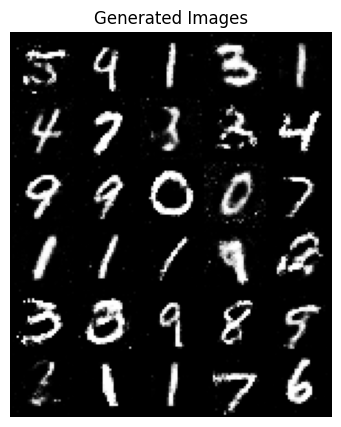

/var/tmp/ipykernel_35311/2191571291.py:72: ExperimentalWarning: upload_artifact is experimental (supported from v3.3.0). The interface can change in the future.
  artifacts_id = upload_artifact(trial, img_path, artifact_store)


running trial number: 1
Batch Size: 128
Learning Rate: 0.00037344819534283286
Optimizer: AdamW
running epoch number: 0


469it [00:12, 37.09it/s]


Epoch [1/100], Step[469/469], d_loss: 1.7655, g_loss: 0.7243, D(x): 0.90, D(G(z)): 0.76
running epoch number: 1


469it [00:12, 37.93it/s]


Epoch [2/100], Step[469/469], d_loss: 0.7483, g_loss: 2.5128, D(x): 0.83, D(G(z)): 0.34
running epoch number: 2


469it [00:12, 37.86it/s]


Epoch [3/100], Step[469/469], d_loss: 0.0725, g_loss: 4.0389, D(x): 0.97, D(G(z)): 0.03
running epoch number: 3


469it [00:12, 37.27it/s]


Epoch [4/100], Step[469/469], d_loss: 0.2835, g_loss: 3.1767, D(x): 0.92, D(G(z)): 0.11
running epoch number: 4


469it [00:12, 38.33it/s]


Epoch [5/100], Step[469/469], d_loss: 0.1245, g_loss: 3.3892, D(x): 0.96, D(G(z)): 0.04
running epoch number: 5


469it [00:12, 37.51it/s]


Epoch [6/100], Step[469/469], d_loss: 0.3597, g_loss: 3.5331, D(x): 0.87, D(G(z)): 0.07
running epoch number: 6


469it [00:12, 38.16it/s]


Epoch [7/100], Step[469/469], d_loss: 0.3423, g_loss: 3.3470, D(x): 0.89, D(G(z)): 0.07
running epoch number: 7


469it [00:12, 37.95it/s]


Epoch [8/100], Step[469/469], d_loss: 0.3884, g_loss: 3.4126, D(x): 0.87, D(G(z)): 0.13
running epoch number: 8


469it [00:12, 37.60it/s]


Epoch [9/100], Step[469/469], d_loss: 0.3576, g_loss: 2.8542, D(x): 0.90, D(G(z)): 0.12
running epoch number: 9


469it [00:12, 38.28it/s]


Epoch [10/100], Step[469/469], d_loss: 0.4630, g_loss: 2.9375, D(x): 0.81, D(G(z)): 0.10
running epoch number: 10


469it [00:12, 38.05it/s]


Epoch [11/100], Step[469/469], d_loss: 0.5914, g_loss: 2.0819, D(x): 0.82, D(G(z)): 0.24
running epoch number: 11


469it [00:12, 38.14it/s]


Epoch [12/100], Step[469/469], d_loss: 0.5367, g_loss: 2.0325, D(x): 0.78, D(G(z)): 0.12
running epoch number: 12


469it [00:12, 37.79it/s]


Epoch [13/100], Step[469/469], d_loss: 0.7472, g_loss: 1.9831, D(x): 0.75, D(G(z)): 0.19
running epoch number: 13


469it [00:12, 37.90it/s]


Epoch [14/100], Step[469/469], d_loss: 0.6520, g_loss: 1.8658, D(x): 0.82, D(G(z)): 0.24
running epoch number: 14


469it [00:12, 38.31it/s]


Epoch [15/100], Step[469/469], d_loss: 0.9114, g_loss: 1.8658, D(x): 0.71, D(G(z)): 0.27
running epoch number: 15


469it [00:12, 38.11it/s]


Epoch [16/100], Step[469/469], d_loss: 0.8568, g_loss: 1.6560, D(x): 0.73, D(G(z)): 0.28
running epoch number: 16


469it [00:12, 38.32it/s]


Epoch [17/100], Step[469/469], d_loss: 0.8799, g_loss: 1.3422, D(x): 0.69, D(G(z)): 0.28
running epoch number: 17


469it [00:12, 38.14it/s]


Epoch [18/100], Step[469/469], d_loss: 0.9292, g_loss: 1.4669, D(x): 0.68, D(G(z)): 0.29
running epoch number: 18


469it [00:12, 38.06it/s]


Epoch [19/100], Step[469/469], d_loss: 0.8910, g_loss: 1.3478, D(x): 0.73, D(G(z)): 0.30
running epoch number: 19


469it [00:12, 37.71it/s]


Epoch [20/100], Step[469/469], d_loss: 0.8747, g_loss: 1.6677, D(x): 0.75, D(G(z)): 0.33
running epoch number: 20


469it [00:12, 37.91it/s]


Epoch [21/100], Step[469/469], d_loss: 0.9601, g_loss: 1.6541, D(x): 0.68, D(G(z)): 0.29
running epoch number: 21


469it [00:12, 38.09it/s]


Epoch [22/100], Step[469/469], d_loss: 0.9596, g_loss: 1.3966, D(x): 0.69, D(G(z)): 0.33
running epoch number: 22


469it [00:12, 38.44it/s]


Epoch [23/100], Step[469/469], d_loss: 0.8913, g_loss: 1.1964, D(x): 0.68, D(G(z)): 0.32
running epoch number: 23


469it [00:12, 38.18it/s]


Epoch [24/100], Step[469/469], d_loss: 0.9424, g_loss: 1.3408, D(x): 0.69, D(G(z)): 0.36
running epoch number: 24


469it [00:12, 38.00it/s]


Epoch [25/100], Step[469/469], d_loss: 1.1192, g_loss: 1.1646, D(x): 0.62, D(G(z)): 0.37
running epoch number: 25


469it [00:12, 37.66it/s]


Epoch [26/100], Step[469/469], d_loss: 1.0358, g_loss: 1.2082, D(x): 0.67, D(G(z)): 0.36
running epoch number: 26


469it [00:12, 38.06it/s]


Epoch [27/100], Step[469/469], d_loss: 1.1422, g_loss: 1.2251, D(x): 0.61, D(G(z)): 0.37
running epoch number: 27


469it [00:12, 38.04it/s]


Epoch [28/100], Step[469/469], d_loss: 1.1331, g_loss: 1.0758, D(x): 0.58, D(G(z)): 0.36
running epoch number: 28


469it [00:12, 37.75it/s]


Epoch [29/100], Step[469/469], d_loss: 1.1644, g_loss: 1.0656, D(x): 0.63, D(G(z)): 0.40
running epoch number: 29


469it [00:12, 37.68it/s]


Epoch [30/100], Step[469/469], d_loss: 1.1799, g_loss: 1.1632, D(x): 0.62, D(G(z)): 0.41
running epoch number: 30


469it [00:12, 37.24it/s]


Epoch [31/100], Step[469/469], d_loss: 1.1109, g_loss: 1.1945, D(x): 0.61, D(G(z)): 0.38
running epoch number: 31


469it [00:12, 37.70it/s]


Epoch [32/100], Step[469/469], d_loss: 1.2004, g_loss: 1.2676, D(x): 0.58, D(G(z)): 0.39
running epoch number: 32


469it [00:12, 37.93it/s]


Epoch [33/100], Step[469/469], d_loss: 1.0514, g_loss: 1.1531, D(x): 0.61, D(G(z)): 0.35
running epoch number: 33


469it [00:12, 37.82it/s]


Epoch [34/100], Step[469/469], d_loss: 1.2155, g_loss: 1.1158, D(x): 0.58, D(G(z)): 0.41
running epoch number: 34


469it [00:12, 38.10it/s]


Epoch [35/100], Step[469/469], d_loss: 1.1401, g_loss: 1.1236, D(x): 0.59, D(G(z)): 0.36
running epoch number: 35


469it [00:12, 37.82it/s]


Epoch [36/100], Step[469/469], d_loss: 1.1656, g_loss: 1.2118, D(x): 0.58, D(G(z)): 0.39
running epoch number: 36


469it [00:12, 38.24it/s]


Epoch [37/100], Step[469/469], d_loss: 1.1038, g_loss: 1.0881, D(x): 0.61, D(G(z)): 0.38
running epoch number: 37


469it [00:12, 37.62it/s]


Epoch [38/100], Step[469/469], d_loss: 1.2612, g_loss: 0.9955, D(x): 0.58, D(G(z)): 0.45
running epoch number: 38


469it [00:12, 38.28it/s]


Epoch [39/100], Step[469/469], d_loss: 1.2032, g_loss: 1.1565, D(x): 0.58, D(G(z)): 0.40
running epoch number: 39


469it [00:12, 38.09it/s]


Epoch [40/100], Step[469/469], d_loss: 1.1589, g_loss: 0.9933, D(x): 0.56, D(G(z)): 0.37
running epoch number: 40


469it [00:12, 37.98it/s]


Epoch [41/100], Step[469/469], d_loss: 1.1137, g_loss: 1.0582, D(x): 0.59, D(G(z)): 0.39
running epoch number: 41


469it [00:12, 38.18it/s]


Epoch [42/100], Step[469/469], d_loss: 1.2310, g_loss: 1.0585, D(x): 0.58, D(G(z)): 0.43
running epoch number: 42


469it [00:12, 37.61it/s]


Epoch [43/100], Step[469/469], d_loss: 1.2173, g_loss: 0.9995, D(x): 0.57, D(G(z)): 0.40
running epoch number: 43


469it [00:12, 37.78it/s]


Epoch [44/100], Step[469/469], d_loss: 1.1238, g_loss: 1.0571, D(x): 0.59, D(G(z)): 0.39
running epoch number: 44


469it [00:12, 38.28it/s]


Epoch [45/100], Step[469/469], d_loss: 1.2341, g_loss: 0.9283, D(x): 0.56, D(G(z)): 0.42
running epoch number: 45


469it [00:12, 37.79it/s]


Epoch [46/100], Step[469/469], d_loss: 1.2019, g_loss: 1.1767, D(x): 0.61, D(G(z)): 0.42
running epoch number: 46


469it [00:12, 38.12it/s]


Epoch [47/100], Step[469/469], d_loss: 1.3255, g_loss: 0.8218, D(x): 0.61, D(G(z)): 0.49
running epoch number: 47


469it [00:12, 37.90it/s]


Epoch [48/100], Step[469/469], d_loss: 1.1403, g_loss: 1.0550, D(x): 0.61, D(G(z)): 0.41
running epoch number: 48


469it [00:12, 37.85it/s]


Epoch [49/100], Step[469/469], d_loss: 1.1141, g_loss: 0.9154, D(x): 0.61, D(G(z)): 0.40
running epoch number: 49


469it [00:12, 37.69it/s]


Epoch [50/100], Step[469/469], d_loss: 1.2128, g_loss: 0.9773, D(x): 0.55, D(G(z)): 0.40
running epoch number: 50


469it [00:12, 37.61it/s]


Epoch [51/100], Step[469/469], d_loss: 1.2365, g_loss: 0.8825, D(x): 0.55, D(G(z)): 0.40
running epoch number: 51


469it [00:12, 37.91it/s]


Epoch [52/100], Step[469/469], d_loss: 1.2148, g_loss: 0.8352, D(x): 0.60, D(G(z)): 0.45
running epoch number: 52


469it [00:12, 37.38it/s]


Epoch [53/100], Step[469/469], d_loss: 1.1372, g_loss: 0.9385, D(x): 0.60, D(G(z)): 0.41
running epoch number: 53


469it [00:12, 37.57it/s]


Epoch [54/100], Step[469/469], d_loss: 1.2270, g_loss: 0.9572, D(x): 0.57, D(G(z)): 0.42
running epoch number: 54


469it [00:12, 37.69it/s]


Epoch [55/100], Step[469/469], d_loss: 1.2561, g_loss: 0.9088, D(x): 0.58, D(G(z)): 0.46
running epoch number: 55


469it [00:12, 38.10it/s]


Epoch [56/100], Step[469/469], d_loss: 1.2136, g_loss: 0.9099, D(x): 0.57, D(G(z)): 0.43
running epoch number: 56


469it [00:12, 38.37it/s]


Epoch [57/100], Step[469/469], d_loss: 1.2044, g_loss: 0.9823, D(x): 0.53, D(G(z)): 0.35
running epoch number: 57


469it [00:12, 37.88it/s]


Epoch [58/100], Step[469/469], d_loss: 1.3014, g_loss: 0.9267, D(x): 0.57, D(G(z)): 0.46
running epoch number: 58


469it [00:12, 38.12it/s]


Epoch [59/100], Step[469/469], d_loss: 1.3557, g_loss: 1.0208, D(x): 0.55, D(G(z)): 0.47
running epoch number: 59


469it [00:12, 38.02it/s]


Epoch [60/100], Step[469/469], d_loss: 1.1467, g_loss: 1.0574, D(x): 0.59, D(G(z)): 0.41
running epoch number: 60


469it [00:12, 38.00it/s]


Epoch [61/100], Step[469/469], d_loss: 1.3489, g_loss: 0.8554, D(x): 0.52, D(G(z)): 0.45
running epoch number: 61


469it [00:12, 38.18it/s]


Epoch [62/100], Step[469/469], d_loss: 1.1605, g_loss: 0.9991, D(x): 0.58, D(G(z)): 0.40
running epoch number: 62


469it [00:12, 37.49it/s]


Epoch [63/100], Step[469/469], d_loss: 1.2753, g_loss: 0.8586, D(x): 0.55, D(G(z)): 0.45
running epoch number: 63


469it [00:12, 38.30it/s]


Epoch [64/100], Step[469/469], d_loss: 1.2628, g_loss: 0.9264, D(x): 0.58, D(G(z)): 0.46
running epoch number: 64


469it [00:12, 37.81it/s]


Epoch [65/100], Step[469/469], d_loss: 1.2631, g_loss: 0.8890, D(x): 0.53, D(G(z)): 0.41
running epoch number: 65


469it [00:12, 38.12it/s]


Epoch [66/100], Step[469/469], d_loss: 1.2190, g_loss: 1.0474, D(x): 0.56, D(G(z)): 0.41
running epoch number: 66


469it [00:12, 38.44it/s]


Epoch [67/100], Step[469/469], d_loss: 1.3318, g_loss: 0.8733, D(x): 0.52, D(G(z)): 0.42
running epoch number: 67


469it [00:12, 38.00it/s]


Epoch [68/100], Step[469/469], d_loss: 1.1125, g_loss: 0.9351, D(x): 0.58, D(G(z)): 0.39
running epoch number: 68


469it [00:12, 37.91it/s]


Epoch [69/100], Step[469/469], d_loss: 1.1552, g_loss: 0.9357, D(x): 0.54, D(G(z)): 0.37
running epoch number: 69


469it [00:12, 37.58it/s]


Epoch [70/100], Step[469/469], d_loss: 1.2704, g_loss: 0.8731, D(x): 0.57, D(G(z)): 0.46
running epoch number: 70


469it [00:12, 38.18it/s]


Epoch [71/100], Step[469/469], d_loss: 1.2899, g_loss: 0.8438, D(x): 0.56, D(G(z)): 0.46
running epoch number: 71


469it [00:12, 38.56it/s]


Epoch [72/100], Step[469/469], d_loss: 1.1992, g_loss: 0.8545, D(x): 0.62, D(G(z)): 0.47
running epoch number: 72


469it [00:12, 37.18it/s]


Epoch [73/100], Step[469/469], d_loss: 1.2727, g_loss: 0.8960, D(x): 0.54, D(G(z)): 0.42
running epoch number: 73


469it [00:12, 38.11it/s]


Epoch [74/100], Step[469/469], d_loss: 1.2181, g_loss: 0.9171, D(x): 0.58, D(G(z)): 0.44
running epoch number: 74


469it [00:12, 37.77it/s]


Epoch [75/100], Step[469/469], d_loss: 1.2405, g_loss: 0.8876, D(x): 0.54, D(G(z)): 0.40
running epoch number: 75


469it [00:12, 38.25it/s]


Epoch [76/100], Step[469/469], d_loss: 1.1886, g_loss: 0.9628, D(x): 0.57, D(G(z)): 0.42
running epoch number: 76


469it [00:12, 37.84it/s]


Epoch [77/100], Step[469/469], d_loss: 1.3378, g_loss: 0.9320, D(x): 0.54, D(G(z)): 0.45
running epoch number: 77


469it [00:12, 37.42it/s]


Epoch [78/100], Step[469/469], d_loss: 1.1441, g_loss: 0.9847, D(x): 0.59, D(G(z)): 0.41
running epoch number: 78


469it [00:12, 37.91it/s]


Epoch [79/100], Step[469/469], d_loss: 1.2598, g_loss: 0.8556, D(x): 0.54, D(G(z)): 0.42
running epoch number: 79


469it [00:12, 37.45it/s]


Epoch [80/100], Step[469/469], d_loss: 1.1883, g_loss: 1.0156, D(x): 0.54, D(G(z)): 0.36
running epoch number: 80


469it [00:12, 37.78it/s]


Epoch [81/100], Step[469/469], d_loss: 1.2196, g_loss: 0.8280, D(x): 0.55, D(G(z)): 0.43
running epoch number: 81


469it [00:12, 37.27it/s]


Epoch [82/100], Step[469/469], d_loss: 1.2965, g_loss: 0.8051, D(x): 0.56, D(G(z)): 0.46
running epoch number: 82


469it [00:12, 37.94it/s]


Epoch [83/100], Step[469/469], d_loss: 1.3120, g_loss: 0.8563, D(x): 0.57, D(G(z)): 0.46
running epoch number: 83


469it [00:12, 38.04it/s]


Epoch [84/100], Step[469/469], d_loss: 1.2647, g_loss: 0.8719, D(x): 0.58, D(G(z)): 0.45
running epoch number: 84


469it [00:12, 37.56it/s]


Epoch [85/100], Step[469/469], d_loss: 1.2904, g_loss: 0.8345, D(x): 0.56, D(G(z)): 0.45
running epoch number: 85


469it [00:12, 38.06it/s]


Epoch [86/100], Step[469/469], d_loss: 1.2341, g_loss: 0.8337, D(x): 0.59, D(G(z)): 0.46
running epoch number: 86


469it [00:12, 37.91it/s]


Epoch [87/100], Step[469/469], d_loss: 1.1831, g_loss: 0.8633, D(x): 0.59, D(G(z)): 0.42
running epoch number: 87


469it [00:12, 38.03it/s]


Epoch [88/100], Step[469/469], d_loss: 1.2300, g_loss: 0.8334, D(x): 0.56, D(G(z)): 0.43
running epoch number: 88


469it [00:12, 38.15it/s]


Epoch [89/100], Step[469/469], d_loss: 1.1766, g_loss: 0.9898, D(x): 0.59, D(G(z)): 0.43
running epoch number: 89


469it [00:12, 37.63it/s]


Epoch [90/100], Step[469/469], d_loss: 1.2317, g_loss: 0.9745, D(x): 0.53, D(G(z)): 0.40
running epoch number: 90


469it [00:12, 38.34it/s]


Epoch [91/100], Step[469/469], d_loss: 1.3141, g_loss: 0.8091, D(x): 0.55, D(G(z)): 0.46
running epoch number: 91


469it [00:12, 37.61it/s]


Epoch [92/100], Step[469/469], d_loss: 1.2087, g_loss: 1.0250, D(x): 0.56, D(G(z)): 0.42
running epoch number: 92


469it [00:12, 38.30it/s]


Epoch [93/100], Step[469/469], d_loss: 1.2638, g_loss: 0.9384, D(x): 0.51, D(G(z)): 0.40
running epoch number: 93


469it [00:12, 38.57it/s]


Epoch [94/100], Step[469/469], d_loss: 1.1762, g_loss: 0.8125, D(x): 0.59, D(G(z)): 0.43
running epoch number: 94


469it [00:12, 37.74it/s]


Epoch [95/100], Step[469/469], d_loss: 1.2837, g_loss: 0.9008, D(x): 0.54, D(G(z)): 0.43
running epoch number: 95


469it [00:12, 38.66it/s]


Epoch [96/100], Step[469/469], d_loss: 1.2927, g_loss: 0.9750, D(x): 0.55, D(G(z)): 0.45
running epoch number: 96


469it [00:12, 37.21it/s]


Epoch [97/100], Step[469/469], d_loss: 1.2154, g_loss: 0.8829, D(x): 0.57, D(G(z)): 0.42
running epoch number: 97


469it [00:12, 38.48it/s]


Epoch [98/100], Step[469/469], d_loss: 1.2416, g_loss: 0.9025, D(x): 0.57, D(G(z)): 0.44
running epoch number: 98


469it [00:12, 38.74it/s]


Epoch [99/100], Step[469/469], d_loss: 1.1503, g_loss: 0.9599, D(x): 0.59, D(G(z)): 0.42
running epoch number: 99


469it [00:12, 37.66it/s]


Epoch [100/100], Step[469/469], d_loss: 1.2102, g_loss: 0.8226, D(x): 0.56, D(G(z)): 0.43


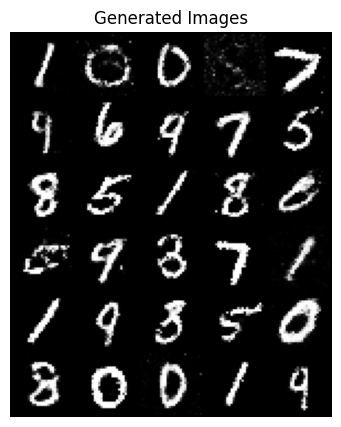

running trial number: 2
Batch Size: 128
Learning Rate: 5.082091373965491e-05
Optimizer: Adam
running epoch number: 0


469it [00:12, 37.77it/s]


Epoch [1/100], Step[469/469], d_loss: 0.3038, g_loss: 3.5745, D(x): 0.89, D(G(z)): 0.12
running epoch number: 1


469it [00:12, 37.84it/s]


Epoch [2/100], Step[469/469], d_loss: 0.1168, g_loss: 3.7381, D(x): 0.98, D(G(z)): 0.08
running epoch number: 2


469it [00:12, 38.03it/s]


Epoch [3/100], Step[469/469], d_loss: 0.0536, g_loss: 4.5292, D(x): 0.99, D(G(z)): 0.03
running epoch number: 3


469it [00:12, 37.56it/s]


Epoch [4/100], Step[469/469], d_loss: 0.1173, g_loss: 4.8144, D(x): 0.96, D(G(z)): 0.05
running epoch number: 4


469it [00:12, 37.45it/s]


Epoch [5/100], Step[469/469], d_loss: 0.0367, g_loss: 6.0850, D(x): 0.99, D(G(z)): 0.01
running epoch number: 5


469it [00:12, 38.44it/s]


Epoch [6/100], Step[469/469], d_loss: 0.0038, g_loss: 7.9094, D(x): 1.00, D(G(z)): 0.00
running epoch number: 6


469it [00:12, 37.85it/s]


Epoch [7/100], Step[469/469], d_loss: 0.0057, g_loss: 6.3872, D(x): 1.00, D(G(z)): 0.00
running epoch number: 7


469it [00:12, 38.49it/s]


Epoch [8/100], Step[469/469], d_loss: 0.0101, g_loss: 6.3066, D(x): 1.00, D(G(z)): 0.01
running epoch number: 8


469it [00:12, 38.66it/s]


Epoch [9/100], Step[469/469], d_loss: 0.0128, g_loss: 8.4127, D(x): 0.99, D(G(z)): 0.01
running epoch number: 9


469it [00:12, 37.89it/s]


Epoch [10/100], Step[469/469], d_loss: 0.0133, g_loss: 7.6823, D(x): 0.99, D(G(z)): 0.00
running epoch number: 10


469it [00:12, 38.50it/s]


Epoch [11/100], Step[469/469], d_loss: 0.0189, g_loss: 8.5927, D(x): 0.99, D(G(z)): 0.00
running epoch number: 11


469it [00:12, 37.96it/s]


Epoch [12/100], Step[469/469], d_loss: 0.0157, g_loss: 8.2323, D(x): 0.99, D(G(z)): 0.00
running epoch number: 12


469it [00:12, 38.41it/s]


Epoch [13/100], Step[469/469], d_loss: 0.0039, g_loss: 9.7953, D(x): 1.00, D(G(z)): 0.00
running epoch number: 13


469it [00:12, 38.03it/s]


Epoch [14/100], Step[469/469], d_loss: 0.0083, g_loss: 6.2825, D(x): 1.00, D(G(z)): 0.01
running epoch number: 14


469it [00:12, 37.77it/s]


Epoch [15/100], Step[469/469], d_loss: 0.0043, g_loss: 8.2011, D(x): 1.00, D(G(z)): 0.00
running epoch number: 15


469it [00:12, 38.26it/s]


Epoch [16/100], Step[469/469], d_loss: 0.0001, g_loss: 12.3608, D(x): 1.00, D(G(z)): 0.00
running epoch number: 16


469it [00:12, 37.86it/s]


Epoch [17/100], Step[469/469], d_loss: 0.0027, g_loss: 9.2754, D(x): 1.00, D(G(z)): 0.00
running epoch number: 17


469it [00:12, 38.01it/s]


Epoch [18/100], Step[469/469], d_loss: 0.0051, g_loss: 9.4953, D(x): 1.00, D(G(z)): 0.00
running epoch number: 18


469it [00:12, 37.54it/s]


Epoch [19/100], Step[469/469], d_loss: 0.0012, g_loss: 11.6032, D(x): 1.00, D(G(z)): 0.00
running epoch number: 19


469it [00:12, 38.11it/s]


Epoch [20/100], Step[469/469], d_loss: 0.0019, g_loss: 9.2942, D(x): 1.00, D(G(z)): 0.00
running epoch number: 20


469it [00:12, 38.12it/s]


Epoch [21/100], Step[469/469], d_loss: 0.0004, g_loss: 11.5685, D(x): 1.00, D(G(z)): 0.00
running epoch number: 21


469it [00:12, 37.87it/s]


Epoch [22/100], Step[469/469], d_loss: 0.0019, g_loss: 8.3042, D(x): 1.00, D(G(z)): 0.00
running epoch number: 22


469it [00:12, 38.18it/s]


Epoch [23/100], Step[469/469], d_loss: 0.0066, g_loss: 10.9815, D(x): 1.00, D(G(z)): 0.01
running epoch number: 23


469it [00:12, 37.79it/s]


Epoch [24/100], Step[469/469], d_loss: 0.0625, g_loss: 11.8804, D(x): 0.99, D(G(z)): 0.00
running epoch number: 24


469it [00:12, 37.79it/s]


Epoch [25/100], Step[469/469], d_loss: 0.0007, g_loss: 10.2419, D(x): 1.00, D(G(z)): 0.00
running epoch number: 25


469it [00:12, 38.03it/s]


Epoch [26/100], Step[469/469], d_loss: 0.0440, g_loss: 11.7036, D(x): 0.99, D(G(z)): 0.00
running epoch number: 26


469it [00:12, 37.83it/s]


Epoch [27/100], Step[469/469], d_loss: 0.0014, g_loss: 8.5601, D(x): 1.00, D(G(z)): 0.00
running epoch number: 27


469it [00:12, 37.90it/s]


Epoch [28/100], Step[469/469], d_loss: 0.0164, g_loss: 7.7482, D(x): 1.00, D(G(z)): 0.01
running epoch number: 28


469it [00:12, 37.73it/s]


Epoch [29/100], Step[469/469], d_loss: 0.0011, g_loss: 9.2537, D(x): 1.00, D(G(z)): 0.00
running epoch number: 29


469it [00:12, 38.20it/s]


Epoch [30/100], Step[469/469], d_loss: 0.0012, g_loss: 10.3920, D(x): 1.00, D(G(z)): 0.00
running epoch number: 30


469it [00:12, 38.46it/s]


Epoch [31/100], Step[469/469], d_loss: 0.0034, g_loss: 10.2037, D(x): 1.00, D(G(z)): 0.00
running epoch number: 31


469it [00:12, 37.44it/s]


Epoch [32/100], Step[469/469], d_loss: 0.0124, g_loss: 8.3686, D(x): 0.99, D(G(z)): 0.00
running epoch number: 32


469it [00:12, 38.65it/s]


Epoch [33/100], Step[469/469], d_loss: 0.0024, g_loss: 11.7936, D(x): 1.00, D(G(z)): 0.00
running epoch number: 33


469it [00:12, 38.01it/s]


Epoch [34/100], Step[469/469], d_loss: 0.0385, g_loss: 10.8285, D(x): 0.99, D(G(z)): 0.00
running epoch number: 34


469it [00:12, 38.41it/s]


Epoch [35/100], Step[469/469], d_loss: 0.0177, g_loss: 28.2379, D(x): 0.99, D(G(z)): 0.00
running epoch number: 35


469it [00:12, 38.70it/s]


Epoch [36/100], Step[469/469], d_loss: 0.0160, g_loss: 11.1629, D(x): 0.99, D(G(z)): 0.00
running epoch number: 36


469it [00:12, 37.77it/s]


Epoch [37/100], Step[469/469], d_loss: 0.0457, g_loss: 6.7557, D(x): 0.98, D(G(z)): 0.00
running epoch number: 37


469it [00:12, 38.66it/s]


Epoch [38/100], Step[469/469], d_loss: 0.1769, g_loss: 6.0651, D(x): 0.95, D(G(z)): 0.00
running epoch number: 38


469it [00:12, 37.75it/s]


Epoch [39/100], Step[469/469], d_loss: 0.0099, g_loss: 9.2729, D(x): 0.99, D(G(z)): 0.00
running epoch number: 39


469it [00:12, 38.44it/s]


Epoch [40/100], Step[469/469], d_loss: 0.0136, g_loss: 6.1783, D(x): 0.99, D(G(z)): 0.01
running epoch number: 40


469it [00:12, 38.32it/s]


Epoch [41/100], Step[469/469], d_loss: 0.0125, g_loss: 6.1310, D(x): 1.00, D(G(z)): 0.01
running epoch number: 41


469it [00:12, 37.88it/s]


Epoch [42/100], Step[469/469], d_loss: 0.0332, g_loss: 4.6135, D(x): 0.99, D(G(z)): 0.02
running epoch number: 42


469it [00:12, 38.58it/s]


Epoch [43/100], Step[469/469], d_loss: 0.0578, g_loss: 6.5315, D(x): 0.98, D(G(z)): 0.00
running epoch number: 43


469it [00:12, 37.97it/s]


Epoch [44/100], Step[469/469], d_loss: 0.0654, g_loss: 5.1050, D(x): 0.98, D(G(z)): 0.02
running epoch number: 44


469it [00:12, 38.62it/s]


Epoch [45/100], Step[469/469], d_loss: 0.0503, g_loss: 5.4908, D(x): 0.99, D(G(z)): 0.02
running epoch number: 45


469it [00:12, 37.78it/s]


Epoch [46/100], Step[469/469], d_loss: 0.2848, g_loss: 3.5804, D(x): 0.97, D(G(z)): 0.15
running epoch number: 46


469it [00:12, 37.83it/s]


Epoch [47/100], Step[469/469], d_loss: 0.1451, g_loss: 3.1859, D(x): 0.97, D(G(z)): 0.07
running epoch number: 47


469it [00:12, 38.01it/s]


Epoch [48/100], Step[469/469], d_loss: 0.1306, g_loss: 4.2241, D(x): 0.96, D(G(z)): 0.03
running epoch number: 48


469it [00:12, 38.02it/s]


Epoch [49/100], Step[469/469], d_loss: 0.1879, g_loss: 3.5517, D(x): 0.96, D(G(z)): 0.07
running epoch number: 49


469it [00:12, 38.62it/s]


Epoch [50/100], Step[469/469], d_loss: 0.2305, g_loss: 3.7642, D(x): 0.94, D(G(z)): 0.07
running epoch number: 50


469it [00:12, 37.62it/s]


Epoch [51/100], Step[469/469], d_loss: 0.1523, g_loss: 3.6380, D(x): 0.98, D(G(z)): 0.07
running epoch number: 51


469it [00:12, 37.65it/s]


Epoch [52/100], Step[469/469], d_loss: 0.2425, g_loss: 3.8507, D(x): 0.93, D(G(z)): 0.03
running epoch number: 52


469it [00:12, 37.18it/s]


Epoch [53/100], Step[469/469], d_loss: 0.2452, g_loss: 2.9434, D(x): 0.94, D(G(z)): 0.10
running epoch number: 53


469it [00:12, 37.50it/s]


Epoch [54/100], Step[469/469], d_loss: 0.2133, g_loss: 4.3074, D(x): 0.95, D(G(z)): 0.07
running epoch number: 54


469it [00:12, 37.87it/s]


Epoch [55/100], Step[469/469], d_loss: 0.2090, g_loss: 3.3770, D(x): 0.94, D(G(z)): 0.05
running epoch number: 55


469it [00:12, 38.07it/s]


Epoch [56/100], Step[469/469], d_loss: 0.3041, g_loss: 3.6052, D(x): 0.91, D(G(z)): 0.05
running epoch number: 56


469it [00:12, 38.31it/s]


Epoch [57/100], Step[469/469], d_loss: 0.3036, g_loss: 2.9815, D(x): 0.92, D(G(z)): 0.09
running epoch number: 57


469it [00:12, 38.57it/s]


Epoch [58/100], Step[469/469], d_loss: 0.2636, g_loss: 2.4606, D(x): 0.95, D(G(z)): 0.15
running epoch number: 58


469it [00:12, 38.63it/s]


Epoch [59/100], Step[469/469], d_loss: 0.3650, g_loss: 2.8324, D(x): 0.90, D(G(z)): 0.06
running epoch number: 59


469it [00:12, 38.74it/s]


Epoch [60/100], Step[469/469], d_loss: 0.2197, g_loss: 3.2054, D(x): 0.94, D(G(z)): 0.06
running epoch number: 60


469it [00:12, 38.66it/s]


Epoch [61/100], Step[469/469], d_loss: 0.2977, g_loss: 3.1113, D(x): 0.90, D(G(z)): 0.06
running epoch number: 61


469it [00:12, 38.03it/s]


Epoch [62/100], Step[469/469], d_loss: 0.2303, g_loss: 3.1664, D(x): 0.95, D(G(z)): 0.09
running epoch number: 62


469it [00:12, 38.22it/s]


Epoch [63/100], Step[469/469], d_loss: 0.4447, g_loss: 2.9711, D(x): 0.85, D(G(z)): 0.05
running epoch number: 63


469it [00:12, 38.25it/s]


Epoch [64/100], Step[469/469], d_loss: 0.4153, g_loss: 2.5266, D(x): 0.89, D(G(z)): 0.11
running epoch number: 64


469it [00:12, 38.23it/s]


Epoch [65/100], Step[469/469], d_loss: 0.2410, g_loss: 2.7878, D(x): 0.94, D(G(z)): 0.08
running epoch number: 65


469it [00:12, 38.34it/s]


Epoch [66/100], Step[469/469], d_loss: 0.3567, g_loss: 3.1015, D(x): 0.89, D(G(z)): 0.09
running epoch number: 66


469it [00:12, 38.72it/s]


Epoch [67/100], Step[469/469], d_loss: 0.2625, g_loss: 2.6432, D(x): 0.92, D(G(z)): 0.09
running epoch number: 67


469it [00:12, 38.05it/s]


Epoch [68/100], Step[469/469], d_loss: 0.4197, g_loss: 2.4392, D(x): 0.86, D(G(z)): 0.11
running epoch number: 68


469it [00:12, 38.40it/s]


Epoch [69/100], Step[469/469], d_loss: 0.5363, g_loss: 2.2650, D(x): 0.85, D(G(z)): 0.14
running epoch number: 69


469it [00:12, 38.11it/s]


Epoch [70/100], Step[469/469], d_loss: 0.3677, g_loss: 2.6984, D(x): 0.90, D(G(z)): 0.12
running epoch number: 70


469it [00:12, 38.13it/s]


Epoch [71/100], Step[469/469], d_loss: 0.3162, g_loss: 2.6998, D(x): 0.91, D(G(z)): 0.11
running epoch number: 71


469it [00:12, 38.31it/s]


Epoch [72/100], Step[469/469], d_loss: 0.3180, g_loss: 2.2142, D(x): 0.92, D(G(z)): 0.13
running epoch number: 72


469it [00:12, 38.10it/s]


Epoch [73/100], Step[469/469], d_loss: 0.2833, g_loss: 2.9679, D(x): 0.93, D(G(z)): 0.07
running epoch number: 73


469it [00:12, 38.39it/s]


Epoch [74/100], Step[469/469], d_loss: 0.3402, g_loss: 2.7326, D(x): 0.88, D(G(z)): 0.07
running epoch number: 74


469it [00:12, 38.65it/s]


Epoch [75/100], Step[469/469], d_loss: 0.3547, g_loss: 2.9710, D(x): 0.92, D(G(z)): 0.11
running epoch number: 75


469it [00:12, 37.56it/s]


Epoch [76/100], Step[469/469], d_loss: 0.3468, g_loss: 2.3854, D(x): 0.92, D(G(z)): 0.13
running epoch number: 76


469it [00:12, 38.68it/s]


Epoch [77/100], Step[469/469], d_loss: 0.5283, g_loss: 2.5940, D(x): 0.85, D(G(z)): 0.10
running epoch number: 77


469it [00:12, 38.07it/s]


Epoch [78/100], Step[469/469], d_loss: 0.4163, g_loss: 2.7299, D(x): 0.84, D(G(z)): 0.08
running epoch number: 78


469it [00:12, 38.20it/s]


Epoch [79/100], Step[469/469], d_loss: 0.4498, g_loss: 2.2602, D(x): 0.84, D(G(z)): 0.11
running epoch number: 79


469it [00:12, 38.32it/s]


Epoch [80/100], Step[469/469], d_loss: 0.4379, g_loss: 2.1023, D(x): 0.87, D(G(z)): 0.13
running epoch number: 80


469it [00:12, 37.43it/s]


Epoch [81/100], Step[469/469], d_loss: 0.2843, g_loss: 2.4710, D(x): 0.92, D(G(z)): 0.10
running epoch number: 81


469it [00:12, 38.52it/s]


Epoch [82/100], Step[469/469], d_loss: 0.2704, g_loss: 2.6253, D(x): 0.92, D(G(z)): 0.10
running epoch number: 82


469it [00:12, 38.28it/s]


Epoch [83/100], Step[469/469], d_loss: 0.3718, g_loss: 2.2828, D(x): 0.88, D(G(z)): 0.13
running epoch number: 83


469it [00:12, 38.02it/s]


Epoch [84/100], Step[469/469], d_loss: 0.7859, g_loss: 2.1463, D(x): 0.74, D(G(z)): 0.11
running epoch number: 84


469it [00:12, 38.17it/s]


Epoch [85/100], Step[469/469], d_loss: 0.4158, g_loss: 2.1946, D(x): 0.91, D(G(z)): 0.17
running epoch number: 85


469it [00:12, 37.78it/s]


Epoch [86/100], Step[469/469], d_loss: 0.4342, g_loss: 2.3040, D(x): 0.87, D(G(z)): 0.14
running epoch number: 86


469it [00:12, 38.15it/s]


Epoch [87/100], Step[469/469], d_loss: 0.4167, g_loss: 2.3454, D(x): 0.89, D(G(z)): 0.14
running epoch number: 87


469it [00:12, 37.84it/s]


Epoch [88/100], Step[469/469], d_loss: 0.3444, g_loss: 2.3789, D(x): 0.90, D(G(z)): 0.13
running epoch number: 88


469it [00:12, 37.91it/s]


Epoch [89/100], Step[469/469], d_loss: 0.5171, g_loss: 2.3222, D(x): 0.83, D(G(z)): 0.13
running epoch number: 89


469it [00:12, 37.79it/s]


Epoch [90/100], Step[469/469], d_loss: 0.5709, g_loss: 2.1341, D(x): 0.81, D(G(z)): 0.14
running epoch number: 90


469it [00:12, 39.08it/s]


Epoch [91/100], Step[469/469], d_loss: 0.6192, g_loss: 2.4462, D(x): 0.81, D(G(z)): 0.14
running epoch number: 91


469it [00:12, 38.54it/s]


Epoch [92/100], Step[469/469], d_loss: 0.4403, g_loss: 2.2287, D(x): 0.87, D(G(z)): 0.14
running epoch number: 92


469it [00:12, 38.62it/s]


Epoch [93/100], Step[469/469], d_loss: 0.4598, g_loss: 2.1682, D(x): 0.86, D(G(z)): 0.15
running epoch number: 93


469it [00:12, 38.55it/s]


Epoch [94/100], Step[469/469], d_loss: 0.4915, g_loss: 2.2619, D(x): 0.88, D(G(z)): 0.17
running epoch number: 94


469it [00:12, 38.08it/s]


Epoch [95/100], Step[469/469], d_loss: 0.5913, g_loss: 2.4412, D(x): 0.80, D(G(z)): 0.12
running epoch number: 95


469it [00:12, 38.32it/s]


Epoch [96/100], Step[469/469], d_loss: 0.4249, g_loss: 2.2797, D(x): 0.86, D(G(z)): 0.13
running epoch number: 96


469it [00:11, 39.20it/s]


Epoch [97/100], Step[469/469], d_loss: 0.4984, g_loss: 2.1623, D(x): 0.84, D(G(z)): 0.15
running epoch number: 97


469it [00:12, 38.88it/s]


Epoch [98/100], Step[469/469], d_loss: 0.5461, g_loss: 2.0434, D(x): 0.84, D(G(z)): 0.18
running epoch number: 98


469it [00:12, 38.82it/s]


Epoch [99/100], Step[469/469], d_loss: 0.4672, g_loss: 2.4431, D(x): 0.86, D(G(z)): 0.13
running epoch number: 99


469it [00:12, 38.43it/s]


Epoch [100/100], Step[469/469], d_loss: 0.4726, g_loss: 2.2794, D(x): 0.85, D(G(z)): 0.13


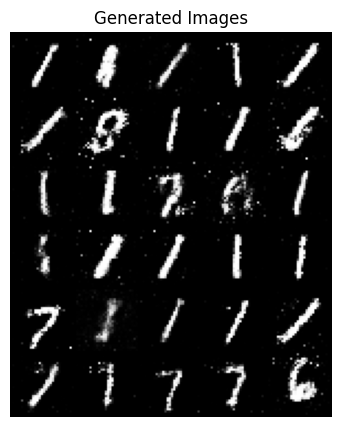

running trial number: 3
Batch Size: 128
Learning Rate: 0.00012200563707968291
Optimizer: Adam
running epoch number: 0


469it [00:12, 38.56it/s]


Epoch [1/100], Step[469/469], d_loss: 0.5306, g_loss: 3.2288, D(x): 0.81, D(G(z)): 0.13
running epoch number: 1


469it [00:12, 38.42it/s]


Epoch [2/100], Step[469/469], d_loss: 0.1117, g_loss: 3.5859, D(x): 0.95, D(G(z)): 0.05
running epoch number: 2


469it [00:12, 39.04it/s]


Epoch [3/100], Step[469/469], d_loss: 0.4400, g_loss: 5.1102, D(x): 0.86, D(G(z)): 0.06
running epoch number: 3


469it [00:12, 38.45it/s]


Epoch [4/100], Step[469/469], d_loss: 0.0840, g_loss: 4.7465, D(x): 0.95, D(G(z)): 0.01
running epoch number: 4


469it [00:12, 37.48it/s]


Epoch [5/100], Step[469/469], d_loss: 0.0019, g_loss: 9.0106, D(x): 1.00, D(G(z)): 0.00
running epoch number: 5


469it [00:12, 37.67it/s]


Epoch [6/100], Step[469/469], d_loss: 0.0540, g_loss: 8.1577, D(x): 0.99, D(G(z)): 0.01
running epoch number: 6


469it [00:12, 38.45it/s]


Epoch [7/100], Step[469/469], d_loss: 0.0069, g_loss: 7.7358, D(x): 1.00, D(G(z)): 0.01
running epoch number: 7


469it [00:12, 38.62it/s]


Epoch [8/100], Step[469/469], d_loss: 0.0366, g_loss: 7.4939, D(x): 0.99, D(G(z)): 0.02
running epoch number: 8


469it [00:12, 38.56it/s]


Epoch [9/100], Step[469/469], d_loss: 0.0055, g_loss: 6.3744, D(x): 1.00, D(G(z)): 0.00
running epoch number: 9


469it [00:12, 38.43it/s]


Epoch [10/100], Step[469/469], d_loss: 0.0626, g_loss: 5.8482, D(x): 0.99, D(G(z)): 0.04
running epoch number: 10


469it [00:12, 38.63it/s]


Epoch [11/100], Step[469/469], d_loss: 0.0264, g_loss: 7.2372, D(x): 0.99, D(G(z)): 0.01
running epoch number: 11


469it [00:12, 38.34it/s]


Epoch [12/100], Step[469/469], d_loss: 0.0736, g_loss: 6.4366, D(x): 0.98, D(G(z)): 0.02
running epoch number: 12


469it [00:12, 38.83it/s]


Epoch [13/100], Step[469/469], d_loss: 0.0576, g_loss: 6.9098, D(x): 1.00, D(G(z)): 0.03
running epoch number: 13


469it [00:12, 38.71it/s]


Epoch [14/100], Step[469/469], d_loss: 0.0893, g_loss: 6.9556, D(x): 0.96, D(G(z)): 0.00
running epoch number: 14


469it [00:12, 38.75it/s]


Epoch [15/100], Step[469/469], d_loss: 0.1206, g_loss: 4.7178, D(x): 0.96, D(G(z)): 0.02
running epoch number: 15


469it [00:12, 37.77it/s]


Epoch [16/100], Step[469/469], d_loss: 0.1754, g_loss: 5.2734, D(x): 0.93, D(G(z)): 0.01
running epoch number: 16


469it [00:12, 38.69it/s]


Epoch [17/100], Step[469/469], d_loss: 0.3015, g_loss: 4.1847, D(x): 0.91, D(G(z)): 0.02
running epoch number: 17


469it [00:12, 38.70it/s]


Epoch [18/100], Step[469/469], d_loss: 0.2241, g_loss: 4.0425, D(x): 0.93, D(G(z)): 0.07
running epoch number: 18


469it [00:12, 38.38it/s]


Epoch [19/100], Step[469/469], d_loss: 0.3956, g_loss: 3.6617, D(x): 0.89, D(G(z)): 0.07
running epoch number: 19


469it [00:12, 38.33it/s]


Epoch [20/100], Step[469/469], d_loss: 0.2187, g_loss: 2.4858, D(x): 0.95, D(G(z)): 0.09
running epoch number: 20


469it [00:12, 38.14it/s]


Epoch [21/100], Step[469/469], d_loss: 0.2016, g_loss: 3.3685, D(x): 0.93, D(G(z)): 0.06
running epoch number: 21


469it [00:12, 38.17it/s]


Epoch [22/100], Step[469/469], d_loss: 0.3834, g_loss: 3.1194, D(x): 0.89, D(G(z)): 0.10
running epoch number: 22


469it [00:12, 38.62it/s]


Epoch [23/100], Step[469/469], d_loss: 0.3206, g_loss: 3.4002, D(x): 0.93, D(G(z)): 0.14
running epoch number: 23


469it [00:12, 38.07it/s]


Epoch [24/100], Step[469/469], d_loss: 0.2997, g_loss: 2.8055, D(x): 0.92, D(G(z)): 0.13
running epoch number: 24


469it [00:12, 38.26it/s]


Epoch [25/100], Step[469/469], d_loss: 0.4411, g_loss: 3.3676, D(x): 0.84, D(G(z)): 0.06
running epoch number: 25


469it [00:12, 38.11it/s]


Epoch [26/100], Step[469/469], d_loss: 0.4972, g_loss: 2.9136, D(x): 0.85, D(G(z)): 0.11
running epoch number: 26


469it [00:12, 38.41it/s]


Epoch [27/100], Step[469/469], d_loss: 0.5358, g_loss: 2.8361, D(x): 0.80, D(G(z)): 0.07
running epoch number: 27


469it [00:12, 38.79it/s]


Epoch [28/100], Step[469/469], d_loss: 0.5345, g_loss: 2.1483, D(x): 0.85, D(G(z)): 0.13
running epoch number: 28


469it [00:12, 38.70it/s]


Epoch [29/100], Step[469/469], d_loss: 0.4651, g_loss: 2.2308, D(x): 0.88, D(G(z)): 0.14
running epoch number: 29


469it [00:12, 38.23it/s]


Epoch [30/100], Step[469/469], d_loss: 0.5952, g_loss: 2.0191, D(x): 0.81, D(G(z)): 0.15
running epoch number: 30


469it [00:12, 38.10it/s]


Epoch [31/100], Step[469/469], d_loss: 0.6531, g_loss: 2.2049, D(x): 0.75, D(G(z)): 0.14
running epoch number: 31


469it [00:12, 38.63it/s]


Epoch [32/100], Step[469/469], d_loss: 0.5125, g_loss: 2.1754, D(x): 0.85, D(G(z)): 0.19
running epoch number: 32


469it [00:12, 38.75it/s]


Epoch [33/100], Step[469/469], d_loss: 0.6672, g_loss: 1.6892, D(x): 0.80, D(G(z)): 0.23
running epoch number: 33


469it [00:12, 38.83it/s]


Epoch [34/100], Step[469/469], d_loss: 0.6999, g_loss: 2.2972, D(x): 0.78, D(G(z)): 0.19
running epoch number: 34


469it [00:12, 38.49it/s]


Epoch [35/100], Step[469/469], d_loss: 0.8003, g_loss: 2.1427, D(x): 0.79, D(G(z)): 0.24
running epoch number: 35


469it [00:12, 38.40it/s]


Epoch [36/100], Step[469/469], d_loss: 0.7062, g_loss: 1.7910, D(x): 0.76, D(G(z)): 0.20
running epoch number: 36


469it [00:12, 38.78it/s]


Epoch [37/100], Step[469/469], d_loss: 0.8563, g_loss: 1.8637, D(x): 0.84, D(G(z)): 0.34
running epoch number: 37


469it [00:12, 38.93it/s]


Epoch [38/100], Step[469/469], d_loss: 0.7783, g_loss: 2.1401, D(x): 0.74, D(G(z)): 0.19
running epoch number: 38


469it [00:12, 38.41it/s]


Epoch [39/100], Step[469/469], d_loss: 0.6554, g_loss: 1.7548, D(x): 0.80, D(G(z)): 0.25
running epoch number: 39


469it [00:12, 38.60it/s]


Epoch [40/100], Step[469/469], d_loss: 0.7088, g_loss: 2.1953, D(x): 0.75, D(G(z)): 0.18
running epoch number: 40


469it [00:12, 38.52it/s]


Epoch [41/100], Step[469/469], d_loss: 0.7634, g_loss: 1.6639, D(x): 0.79, D(G(z)): 0.27
running epoch number: 41


469it [00:12, 38.48it/s]


Epoch [42/100], Step[469/469], d_loss: 0.8006, g_loss: 1.9426, D(x): 0.73, D(G(z)): 0.20
running epoch number: 42


469it [00:12, 38.71it/s]


Epoch [43/100], Step[469/469], d_loss: 0.7783, g_loss: 1.5411, D(x): 0.74, D(G(z)): 0.25
running epoch number: 43


469it [00:12, 37.57it/s]


Epoch [44/100], Step[469/469], d_loss: 0.7020, g_loss: 1.4834, D(x): 0.79, D(G(z)): 0.27
running epoch number: 44


469it [00:12, 38.82it/s]


Epoch [45/100], Step[469/469], d_loss: 0.7476, g_loss: 1.6064, D(x): 0.75, D(G(z)): 0.22
running epoch number: 45


469it [00:12, 37.87it/s]


Epoch [46/100], Step[469/469], d_loss: 0.7768, g_loss: 1.5919, D(x): 0.74, D(G(z)): 0.25
running epoch number: 46


469it [00:12, 38.63it/s]


Epoch [47/100], Step[469/469], d_loss: 0.9067, g_loss: 1.8908, D(x): 0.72, D(G(z)): 0.27
running epoch number: 47


469it [00:12, 38.82it/s]


Epoch [48/100], Step[469/469], d_loss: 0.7637, g_loss: 1.5770, D(x): 0.80, D(G(z)): 0.28
running epoch number: 48


469it [00:12, 37.66it/s]


Epoch [49/100], Step[469/469], d_loss: 0.6048, g_loss: 1.8578, D(x): 0.79, D(G(z)): 0.23
running epoch number: 49


469it [00:12, 38.97it/s]


Epoch [50/100], Step[469/469], d_loss: 0.7397, g_loss: 1.7281, D(x): 0.75, D(G(z)): 0.24
running epoch number: 50


469it [00:12, 38.68it/s]


Epoch [51/100], Step[469/469], d_loss: 0.7621, g_loss: 1.6969, D(x): 0.71, D(G(z)): 0.23
running epoch number: 51


469it [00:12, 38.64it/s]


Epoch [52/100], Step[469/469], d_loss: 0.7960, g_loss: 1.7413, D(x): 0.74, D(G(z)): 0.27
running epoch number: 52


469it [00:12, 38.84it/s]


Epoch [53/100], Step[469/469], d_loss: 0.8113, g_loss: 1.5208, D(x): 0.74, D(G(z)): 0.29
running epoch number: 53


469it [00:12, 38.13it/s]


Epoch [54/100], Step[469/469], d_loss: 0.7977, g_loss: 1.4505, D(x): 0.73, D(G(z)): 0.28
running epoch number: 54


469it [00:12, 38.41it/s]


Epoch [55/100], Step[469/469], d_loss: 0.8294, g_loss: 1.5799, D(x): 0.73, D(G(z)): 0.29
running epoch number: 55


469it [00:12, 37.78it/s]


Epoch [56/100], Step[469/469], d_loss: 0.7776, g_loss: 1.7962, D(x): 0.68, D(G(z)): 0.20
running epoch number: 56


469it [00:12, 38.56it/s]


Epoch [57/100], Step[469/469], d_loss: 0.7928, g_loss: 1.3060, D(x): 0.75, D(G(z)): 0.27
running epoch number: 57


469it [00:12, 38.84it/s]


Epoch [58/100], Step[469/469], d_loss: 0.7820, g_loss: 1.6286, D(x): 0.70, D(G(z)): 0.22
running epoch number: 58


469it [00:12, 38.61it/s]


Epoch [59/100], Step[469/469], d_loss: 0.9463, g_loss: 1.4433, D(x): 0.75, D(G(z)): 0.35
running epoch number: 59


469it [00:12, 38.94it/s]


Epoch [60/100], Step[469/469], d_loss: 0.8897, g_loss: 1.5547, D(x): 0.72, D(G(z)): 0.28
running epoch number: 60


469it [00:12, 37.80it/s]


Epoch [61/100], Step[469/469], d_loss: 0.9546, g_loss: 1.3740, D(x): 0.67, D(G(z)): 0.27
running epoch number: 61


469it [00:12, 39.02it/s]


Epoch [62/100], Step[469/469], d_loss: 0.8342, g_loss: 1.3801, D(x): 0.71, D(G(z)): 0.27
running epoch number: 62


469it [00:12, 38.59it/s]


Epoch [63/100], Step[469/469], d_loss: 0.8538, g_loss: 1.5488, D(x): 0.73, D(G(z)): 0.31
running epoch number: 63


469it [00:12, 37.64it/s]


Epoch [64/100], Step[469/469], d_loss: 0.8633, g_loss: 1.5199, D(x): 0.71, D(G(z)): 0.28
running epoch number: 64


469it [00:12, 38.77it/s]


Epoch [65/100], Step[469/469], d_loss: 0.8080, g_loss: 1.5646, D(x): 0.71, D(G(z)): 0.27
running epoch number: 65


469it [00:12, 38.12it/s]


Epoch [66/100], Step[469/469], d_loss: 0.8182, g_loss: 1.5061, D(x): 0.73, D(G(z)): 0.28
running epoch number: 66


469it [00:12, 38.83it/s]


Epoch [67/100], Step[469/469], d_loss: 1.0338, g_loss: 1.3651, D(x): 0.64, D(G(z)): 0.32
running epoch number: 67


469it [00:12, 38.64it/s]


Epoch [68/100], Step[469/469], d_loss: 0.9886, g_loss: 1.4215, D(x): 0.71, D(G(z)): 0.33
running epoch number: 68


469it [00:12, 38.40it/s]


Epoch [69/100], Step[469/469], d_loss: 0.8898, g_loss: 1.4966, D(x): 0.68, D(G(z)): 0.27
running epoch number: 69


469it [00:12, 38.70it/s]


Epoch [70/100], Step[469/469], d_loss: 0.7500, g_loss: 1.3698, D(x): 0.76, D(G(z)): 0.27
running epoch number: 70


469it [00:12, 38.34it/s]


Epoch [71/100], Step[469/469], d_loss: 1.0036, g_loss: 1.2720, D(x): 0.77, D(G(z)): 0.41
running epoch number: 71


469it [00:12, 38.65it/s]


Epoch [72/100], Step[469/469], d_loss: 0.8299, g_loss: 1.4239, D(x): 0.77, D(G(z)): 0.34
running epoch number: 72


469it [00:12, 38.97it/s]


Epoch [73/100], Step[469/469], d_loss: 0.9470, g_loss: 1.6472, D(x): 0.65, D(G(z)): 0.24
running epoch number: 73


469it [00:12, 37.66it/s]


Epoch [74/100], Step[469/469], d_loss: 0.8095, g_loss: 1.5281, D(x): 0.72, D(G(z)): 0.26
running epoch number: 74


469it [00:12, 38.87it/s]


Epoch [75/100], Step[469/469], d_loss: 0.9319, g_loss: 1.3121, D(x): 0.67, D(G(z)): 0.30
running epoch number: 75


469it [00:12, 38.50it/s]


Epoch [76/100], Step[469/469], d_loss: 0.7496, g_loss: 1.4930, D(x): 0.75, D(G(z)): 0.29
running epoch number: 76


469it [00:12, 38.61it/s]


Epoch [77/100], Step[469/469], d_loss: 0.8324, g_loss: 1.3118, D(x): 0.75, D(G(z)): 0.32
running epoch number: 77


469it [00:12, 38.58it/s]


Epoch [78/100], Step[469/469], d_loss: 0.8539, g_loss: 1.5083, D(x): 0.70, D(G(z)): 0.28
running epoch number: 78


469it [00:12, 38.06it/s]


Epoch [79/100], Step[469/469], d_loss: 0.8317, g_loss: 1.5142, D(x): 0.69, D(G(z)): 0.25
running epoch number: 79


469it [00:11, 39.15it/s]


Epoch [80/100], Step[469/469], d_loss: 0.9006, g_loss: 1.3590, D(x): 0.71, D(G(z)): 0.31
running epoch number: 80


469it [00:12, 37.72it/s]


Epoch [81/100], Step[469/469], d_loss: 0.7604, g_loss: 1.4825, D(x): 0.77, D(G(z)): 0.31
running epoch number: 81


469it [00:12, 37.80it/s]


Epoch [82/100], Step[469/469], d_loss: 0.9663, g_loss: 1.2064, D(x): 0.67, D(G(z)): 0.30
running epoch number: 82


469it [00:12, 39.00it/s]


Epoch [83/100], Step[469/469], d_loss: 1.1493, g_loss: 1.2152, D(x): 0.73, D(G(z)): 0.42
running epoch number: 83


469it [00:12, 38.02it/s]


Epoch [84/100], Step[469/469], d_loss: 0.9250, g_loss: 1.2674, D(x): 0.69, D(G(z)): 0.30
running epoch number: 84


469it [00:12, 38.78it/s]


Epoch [85/100], Step[469/469], d_loss: 1.0545, g_loss: 1.4671, D(x): 0.69, D(G(z)): 0.35
running epoch number: 85


469it [00:12, 37.51it/s]


Epoch [86/100], Step[469/469], d_loss: 0.9532, g_loss: 1.3407, D(x): 0.72, D(G(z)): 0.33
running epoch number: 86


469it [00:12, 38.31it/s]


Epoch [87/100], Step[469/469], d_loss: 0.9563, g_loss: 1.2874, D(x): 0.66, D(G(z)): 0.31
running epoch number: 87


469it [00:12, 38.20it/s]


Epoch [88/100], Step[469/469], d_loss: 1.0516, g_loss: 1.3846, D(x): 0.70, D(G(z)): 0.36
running epoch number: 88


469it [00:12, 38.35it/s]


Epoch [89/100], Step[469/469], d_loss: 1.0092, g_loss: 1.3882, D(x): 0.70, D(G(z)): 0.33
running epoch number: 89


469it [00:12, 38.83it/s]


Epoch [90/100], Step[469/469], d_loss: 0.9106, g_loss: 1.4256, D(x): 0.65, D(G(z)): 0.28
running epoch number: 90


469it [00:12, 37.89it/s]


Epoch [91/100], Step[469/469], d_loss: 0.9623, g_loss: 1.3138, D(x): 0.68, D(G(z)): 0.31
running epoch number: 91


469it [00:12, 38.73it/s]


Epoch [92/100], Step[469/469], d_loss: 0.9871, g_loss: 1.4286, D(x): 0.69, D(G(z)): 0.31
running epoch number: 92


469it [00:12, 38.08it/s]


Epoch [93/100], Step[469/469], d_loss: 0.9068, g_loss: 1.0814, D(x): 0.67, D(G(z)): 0.29
running epoch number: 93


469it [00:12, 38.48it/s]


Epoch [94/100], Step[469/469], d_loss: 0.8708, g_loss: 1.3609, D(x): 0.73, D(G(z)): 0.30
running epoch number: 94


469it [00:12, 38.89it/s]


Epoch [95/100], Step[469/469], d_loss: 0.7419, g_loss: 1.4272, D(x): 0.72, D(G(z)): 0.25
running epoch number: 95


469it [00:12, 37.97it/s]


Epoch [96/100], Step[469/469], d_loss: 0.9649, g_loss: 1.2844, D(x): 0.66, D(G(z)): 0.31
running epoch number: 96


469it [00:11, 39.10it/s]


Epoch [97/100], Step[469/469], d_loss: 1.0096, g_loss: 1.3677, D(x): 0.67, D(G(z)): 0.32
running epoch number: 97


469it [00:12, 38.44it/s]


Epoch [98/100], Step[469/469], d_loss: 0.9287, g_loss: 1.3098, D(x): 0.71, D(G(z)): 0.35
running epoch number: 98


469it [00:12, 38.23it/s]


Epoch [99/100], Step[469/469], d_loss: 0.9877, g_loss: 1.3077, D(x): 0.67, D(G(z)): 0.31
running epoch number: 99


469it [00:12, 38.10it/s]


Epoch [100/100], Step[469/469], d_loss: 1.0023, g_loss: 1.3204, D(x): 0.66, D(G(z)): 0.32


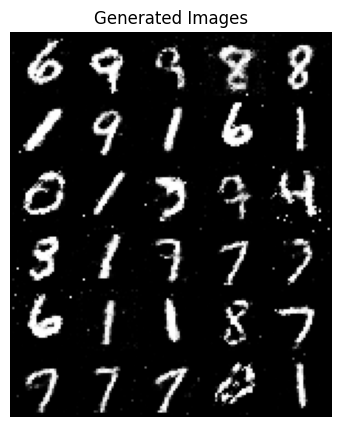

KeyboardInterrupt: 

In [11]:
if __name__ == "__main__":
    main()